In [22]:
!ls /datasets/
!ls /tmp
# !unzip /datasets/aroi/AROI_labelled_scans.zip -d /tmp/

aroi
AROI_labelled_scans  __autograph_generated_fileo5xmvqic.py  __pycache__


In [23]:
!nvidia-smi

Tue Jan 24 23:34:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        Off  | 00000000:00:05.0 Off |                  Off |
| 26%   37C    P8     6W / 180W |  16021MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import math

import PIL
import PIL.Image
import PIL.ImageOps

from skimage.io import imread
from scipy.ndimage import rotate
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import load_img

import utils

In [25]:
AROI_DATA = Path("/tmp/AROI_labelled_scans/24_patient/")
if not AROI_DATA.exists():
    print("Extracting data...")
    import zipfile
    with zipfile.ZipFile("/datasets/aroi/AROI_labelled_scans.zip", 'r') as zip_ref:
        zip_ref.extractall("/tmp")

assert AROI_DATA.exists()  # If this fails then dataset is not present and something is very wrong!

In [26]:
IMG_WIDTH_ORIGINAL=512
IMG_HEIGHT_ORIGINAL=1024
IMG_WIDTH = 256
IMG_HEIGHT = 512
IMG_CHANNELS = 1 # grayscale images
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
NUM_CLASSES = 8 #8 in case just fluids is 4, in case fluids and layers is 8
BATCH_SIZE = 4 # try 4, 8, 12, 16, 32


In [27]:
raw_image_path = sorted([file for file in AROI_DATA.glob("**/raw/labeled/*png")])
segmented_image_path = sorted([file for file in AROI_DATA.glob("**/mask/number/*png")])

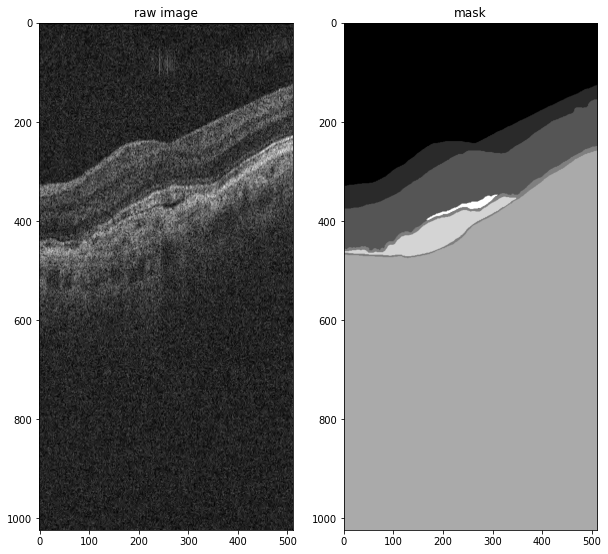

(array([358530,  60906,      0, 142857,  16014,      0, 960759,      0,
        30222,   3576]), array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
       229.5, 255. ]))


In [28]:

#i = np.random.randint(0,len(m))
i = 13
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('raw image')
#raw = load_img(input_train_paths[i])
raw = PIL.ImageOps.autocontrast(load_img(raw_image_path[i]))

plt.imshow(raw)

plt.subplot(1, 2, 2)
plt.title('mask')
mask = PIL.ImageOps.autocontrast(load_img(segmented_image_path[i]))
plt.imshow(mask)

plt.show()

print(np.histogram(mask))

In [29]:
X_train_paths, X_val_paths, X_test_paths, y_train_paths, y_val_paths, y_test_paths = utils.train_test_validate_split(raw_image_path, segmented_image_path)
print(f"---> {len(X_train_paths)} images within the TRAIN dataset")
print(f"---> {len(X_val_paths)} images within the VALIDATE dataset")
print(f"---> {len(X_test_paths)} images within the TEST dataset")

---> 852 images within the TRAIN dataset
---> 170 images within the VALIDATE dataset
---> 114 images within the TEST dataset


# UNet Implimentation

In [30]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

BATCH_SIZE = 4

In [31]:
class AROISequence(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""
    seed = 42
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_train_paths = input_img_paths
        self.target_train_paths = target_img_paths

    def __len__(self):
        return math.ceil(len(self.target_train_paths) / self.batch_size)

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_train_paths = self.input_train_paths[i : i + self.batch_size]
        batch_target_train_paths = self.target_train_paths[i : i + self.batch_size]
        x = np.zeros((BATCH_SIZE,) + self.img_size + (1,), dtype="float32")
        flp = np.zeros((BATCH_SIZE,) + self.img_size + (1,))
        angle = np.zeros((BATCH_SIZE,) + self.img_size + (1,))
        
        for j, path in enumerate(batch_input_train_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img=np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
            seed = 13
            np.random.seed = 13
            #flipping
            flp [j] = np.random.randint(0,3)
            flp = np.append (flp, flp[j])
            if flp [j] ==1:
              img = np.fliplr(img)
            #rotating
            angle[j] = np.random.randint(-8, 8)
            angle = np.append(angle, angle[j])
            img = rotate(img, angle[j], reshape=False, mode='nearest', order=0)
            x[j] = img/.255
        y = np.zeros((BATCH_SIZE,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_train_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
            if flp [j] ==1:
              img = np.fliplr(img)
            img = rotate(img, angle[j], reshape=False, mode='nearest', order=0)
            y[j] = img
        return x, y



In [32]:
class AROISequenceNoTransform(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_train_paths = input_img_paths
        self.target_train_paths = target_img_paths

    def __len__(self):
        return math.ceil(len(self.target_train_paths) / self.batch_size)

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_train_paths = self.input_train_paths[i : i + self.batch_size]
        batch_target_train_paths = self.target_train_paths[i : i + self.batch_size]
        x = np.zeros((BATCH_SIZE,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_input_train_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img=np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
            x[j] = img/.255
        y = np.zeros((BATCH_SIZE,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_train_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
            y[j] = img
        return x, y

        

In [33]:
train_seq = AROISequence(BATCH_SIZE, IMG_SIZE, X_train_paths, y_train_paths)
validate_seq = AROISequenceNoTransform(BATCH_SIZE, IMG_SIZE, X_val_paths, y_val_paths)
test_seq = AROISequenceNoTransform(BATCH_SIZE, IMG_SIZE, X_test_paths, y_test_paths)

In [34]:
def originial_unet(img_size, num_classes):
    """
    Implementation of original UNet model
    """
    
    inputs = keras.Input(shape=img_size + (1,))

    conv1 = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation("relu")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation("relu")(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, (3, 3), padding='same')(pool2)
    conv3 = layers.Conv2D(128, (3, 3), padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation("relu")(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(256, (3, 3), padding='same')(pool3)
    conv4 = layers.Conv2D(256, (3, 3), padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation("relu")(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(512, (3, 3), padding='same')(pool4)
    conv5 = layers.Conv2D(512, (3, 3), padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation("relu")(conv5)

    x6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = layers.add([x6, conv4])
    conv6 = layers.Conv2D(256, (3, 3), padding='same')(up6)
    conv6 = layers.Conv2D(256, (3, 3), padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation("relu")(conv6)

    x7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2),padding='same')(conv6)
    up7 = layers.add([x7, conv3])
    conv7 = layers.Conv2D(128, (3, 3), padding='same')(up7)
    conv7 = layers.Conv2D(128, (3, 3), padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation("relu")(conv7)

    x8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = layers.add([x8, conv2])
    conv8 = layers.Conv2D(64, (3, 3), padding='same')(up8)
    conv8 = layers.Conv2D(64, (3, 3), padding='same')(conv8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Activation("relu")(conv8)

    x9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = layers.add([x9, conv1])
    conv9 = layers.Conv2D(32, (3, 3), padding='same')(up9)
    conv9 = layers.Conv2D(32, (3, 3), padding='same')(conv9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Activation("relu")(conv9)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(conv9)
    
    # Define the model
    model = keras.Model(inputs, outputs)
   
       
    return model

In [35]:
model = originial_unet(IMG_SIZE, NUM_CLASSES)
# model.summary()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

In [36]:
log_dir = "/tmp/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [
    #keras.callbacks.ModelCheckpoint("OCT_segmentation.h5", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1),
    tensorboard_callback
]
# Train the model, doing validation at the end of each epoch.
epochs = 10
model_history = model.fit(train_seq, epochs=epochs, validation_data=validate_seq, callbacks=callbacks)

Epoch 1/10
213/213 [==============================] - 31s 135ms/step - loss: 0.3131 - val_loss: 5.5095
Epoch 2/10
213/213 [==============================] - 29s 134ms/step - loss: 0.1407 - val_loss: 1.2338
Epoch 3/10
213/213 [==============================] - 29s 134ms/step - loss: 0.1154 - val_loss: 1.1201
Epoch 4/10
213/213 [==============================] - 29s 133ms/step - loss: 0.1024 - val_loss: 0.2403
Epoch 5/10
213/213 [==============================] - 29s 134ms/step - loss: 0.0880 - val_loss: 0.1062
Epoch 6/10
213/213 [==============================] - 29s 137ms/step - loss: 0.0744 - val_loss: 0.1542
Epoch 7/10
213/213 [==============================] - 29s 134ms/step - loss: 0.0709 - val_loss: 0.4885
Epoch 8/10
213/213 [==============================] - 29s 135ms/step - loss: 0.0684 - val_loss: 0.1847
Epoch 9/10
213/213 [==============================] - 29s 136ms/step - loss: 0.0754 - val_loss: 0.2020
Epoch 10/10
213/213 [==============================] - 29s 135ms/step - l

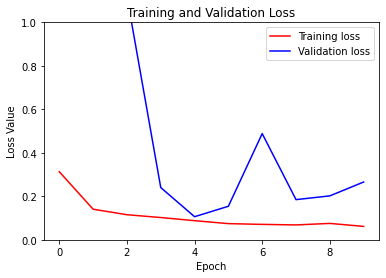

In [37]:
# Plotting loss and validation loss
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(model_history.epoch))

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [38]:
test_preds = model.predict(test_seq)
predictions = np.argmax(test_preds, axis=-1)

29/29 [==============================] - 2s 47ms/step


In [39]:
model.save(f"oct_model_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}")
# model = keras.models.load_model("oct_model_20230124-230633")

INFO:tensorflow:Assets written to: oct_model_20230124-233945/assets


INFO:tensorflow:Assets written to: oct_model_20230124-233945/assets


Image id: 85
Image id: 85 /tmp/AROI_labelled_scans/24_patient/patient9/raw/labeled/patient9_raw0047.png


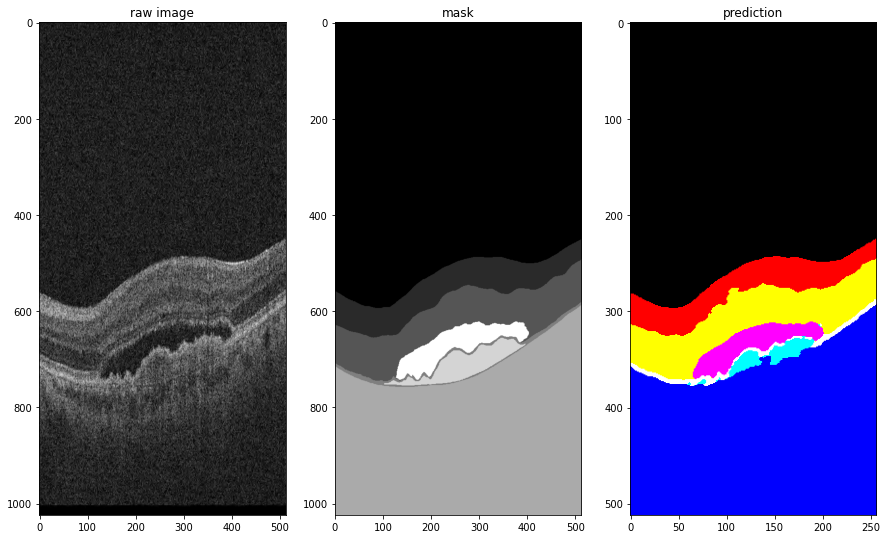

In [42]:
import utils

m=X_test_paths
i = np.random.randint(0,len(X_test_paths))
#i=11 #0, 133, 119
print('Image id:', i )
print('Image id:', i ,  m[i])
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title('raw image')
raw = PIL.ImageOps.autocontrast(load_img(X_test_paths[i]))
plt.imshow(raw)
plt.subplot(1, 3, 2)
plt.title('mask')
mask = PIL.ImageOps.autocontrast(load_img(y_test_paths[i]))
plt.imshow(mask)
plt.subplot(1, 3, 3)
plt.title('prediction')
pred = np.argmax(test_preds[i], axis=-1)
pred = np.expand_dims(pred, axis=-1)
pred = utils.num_to_colors(pred, IMG_HEIGHT, IMG_WIDTH)
# pred = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(pred))
plt.imshow(pred)


plt.show()

In [43]:
utils.calculate_f1_micro_macro(test_seq, predictions)

Macro F1: 0.7217139301211888
Micro F1: 0.8991249347555226
